In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sklearn.datasets as skdata
import scipy.stats

# Implementing diffusion generative model

We start with the model setup descibed in https://arxiv.org/pdf/1503.03585.pdf. 


For a simple test case, we will start with 2-d swiss roll data and attempt to reconstruct it. See Figure 1 of the above paper for a reference. 




Let's start by making and plotting some swiss roll data.

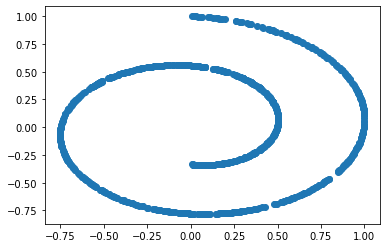

In [399]:
n_samples = 1000
x,t = skdata.make_swiss_roll(n_samples = n_samples)
# x.shape = (n_samples,3)
x0 = x[:,[0,2]]  # Project to 2d and scale down
x0 = x0 / np.amax(x0,axis = 0)

plt.scatter(x0[:,0], x0[:,1] )
plt.show()

We'll wish to evolve these samples into samples from a 2-d standard Gaussian, so we scale down the values to close match the range of expected Gaussian values. let's now plot samples from a standard Gaussian.

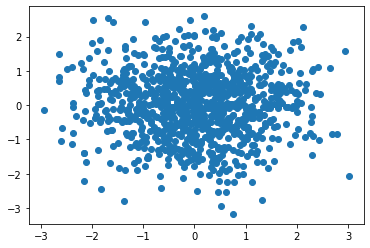

In [203]:
xT = np.random.randn(n_samples,2)
plt.scatter(xT[:,0],xT[:,1])
plt.show()

Alright, now we want to evolve our data (x0) into our sample distribution(xT). We will do so by iterating

$$
x_{n+1} = \sqrt{\beta_n} x_n + (1 - \beta_n) \omega_n , \quad \omega_n \sim N(0,1)
$$

In [206]:
T = 10
xp = x0
xm = x0
beta = np.linspace(0.9, 0.2, T)
for n in range(T):
    xp = np.sqrt(beta[n])*xp + (1-beta[n]) * np.random.randn(xp.shape[0],xp.shape[1])
    xm = -np.sqrt(beta[n])*xm + (1-beta[n]) * np.random.randn(xm.shape[0],xm.shape[1])
    

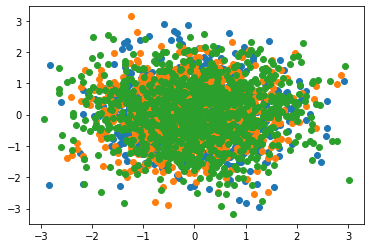

In [207]:
# plt.scatter(x0[:,0],x0[:,1])
plt.scatter(xp[:,0],xp[:,1])
plt.scatter(xm[:,0],xm[:,1])
plt.scatter(xT[:,0],xT[:,1])
plt.show()

# Implementation of Denoising Diffusion Probabilistic Models (DDPM)

The paper https://arxiv.org/pdf/2006.11239.pdf takes the training process of the earlier paper and shows that one can train with an equivalent and much simpler loss function. This comes at the cost of a slightly more complicated method of sampling from the data distribution but the cost seems well worth it. In particular we may train via


- sample $x_0 \sim q(x_0)$ where $q_0$ is the data distribution
- sample $t \sim \text{Uniform}(0,\dots, T)$
- sample $\epsilon \sim N(0,1)$
- train with $\mathcal{L} = \| \epsilon - \epsilon_\theta(\sqrt{\bar a_t} x_0 + \sqrt{1-\bar a_t} \epsilon,t) \| ^2$


Where $a_t = 1 - \beta_t, \bar a_t = \Pi_{i=1}^t a_i$ and we progressively add noise to $x_0$ following the rule

$$
q(x_t | x_{t-1}) \sim N(\sqrt{1-\beta_t} x_{t-1}, \beta_t I)
$$

As the addition of Gaussians is Gaussian we see

$$
q(x_t | x_{0}) \sim N(\sqrt{\bar a_t} x_{0}, (1 - \bar a_t) I)
$$



###### Training a generative model

Then, (as the Kolmogorov equations will show) training a defusion model to generate samples from the data distribution can be done by learning 

$$
p_\theta(x_{t-1} | x_t) := N(\mu(x_t,t) , \Sigma(x_t,t))  
$$




When we train in the simplified manner of DDPMs, the $\beta_t$ in the forward process are taken to be fixed and the variances of the backward process are taken to be 

$$
\Sigma(x_t,t) = \beta_t
$$


Thus, learning will amount to learning the mean function $\mu(x_t,t)$. As the paper shows, it suffices to learn $\epsilon(x_t,t)$ where 

$$
\mu(x_t,t) = \frac{1}{\sqrt{a_t}} \left ( x_t - \frac{\beta_t}{\sqrt{1- \bar \alpha_t}} \epsilon_\theta(x_t,t) \right)
$$

Where $\epsilon_\theta$ is intented to predict standard Gaussian noise. 



#### Noah Commenting

That's crazy, how does that even work? We're gonna have to go through this some more. The paper does a pretty ok job of explaining it, but clearly this explanation is not the focus of the paper. If we could describe it well that would be a good contribution.



### My Notes on the training algorithm

- The model $\epsilon_\theta(x_t,t)$ must be time dependant. This is not always so easy to do
- Must output is the same dimension as the data

In [2]:
class PositionalEncoding(nn.Module):

    def __init__(self, data_dim: int, T : int):
        super().__init__()
        
        position = torch.arange(T).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, data_dim, 2) * (-math.log(10000.0) / data_dim))
        pe = torch.zeros(T, data_dim)
        pe[:,  0::2] = torch.sin(position * div_term)
        pe[:,  1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, time_indices):
        """
        Args:
            t: Tensor, shape [batch_size]
        """

        return self.pe[time_indices,:]
        
class Epsilon(nn.Module):
    ''' Epsilon theta for generative models '''
    def __init__(self, input_dim: int, max_time : int, hidden_dim: int = 32) -> None:
        super(Epsilon, self).__init__()
        self.input_dim = input_dim
        
        # Positional encoding related parameters
        self.positional_encoding = PositionalEncoding(input_dim, max_time)        
        self.pe_fc1 = nn.Linear(input_dim, hidden_dim)
                                        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        
        
    def encode_position(self,t):
        pe = self.positional_encoding(t)
        pe = F.relu(self.pe_fc1(pe))
        return pe
        
        
    def forward(self, x, t):     
        x = x.view(-1, self.input_dim) # make data 1-d        
        pe = self.encode_position(t) # Get the positional encodings        
        
        x = self.fc1(x) + pe # Add in positional encodings
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
# Define some helper functions

def get_2d_swiss_roll(n_samples : int):
    x,t = skdata.make_swiss_roll(n_samples = n_samples)    
    x = x[:,[0,2]] # Project to 2d and scale down
    x = x / np.amax(x,axis = 0)
    return torch.tensor(x, dtype = torch.float32)

def get_betas_and_alphas(low, high,T):
    betas = torch.linspace(1e-4, 0.2, T)
    alphas = 1- betas
    return betas, alphas

def get_alpha_bars(alphas):
    return torch.cumprod(alphas, dim = 0)
    

In [37]:
# Define training parameters
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

epochs = 8000
batch_size = 128
T = 1000

model = Epsilon(2, max_time = T)
model.to(device)

loss_function = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(),lr = 2e-4)


betas, alphas = get_betas_and_alphas(1e-4,0.2, T)
alphabar = get_alpha_bars(alphas)

In [38]:
## Train the model
model.train()
for epoch in range(epochs): 
    optimizer.zero_grad()
    
    # Get data and target
    X = get_2d_swiss_roll(batch_size)
    target = torch.randn_like(X)
    times = torch.randint(low = 1, high= T, size = (batch_size,))
    
    
    # Update X to be sqrt(bar a_t) X + sqrt(1- bar a_t) target
    at = alphabar[times]
    X = torch.sqrt(at)[:,None] * X + torch.sqrt(1 - at)[:,None] * target
            
    X, times, target = X.to(device), times.to(device), target.to(device)
            
    output = model(X,times)            
    loss = loss_function(output, target)            
    loss.backward()
    optimizer.step()
        
    if epoch % 1000 == 0:
        print(f'Epoch {epoch} ---- Loss {loss.item()}')


Epoch 0 ---- Loss 0.8318552374839783
Epoch 1000 ---- Loss 0.10279431939125061
Epoch 2000 ---- Loss 0.11014141142368317
Epoch 3000 ---- Loss 0.08440965414047241
Epoch 4000 ---- Loss 0.060090187937021255
Epoch 5000 ---- Loss 0.06342232972383499
Epoch 6000 ---- Loss 0.06190996244549751
Epoch 7000 ---- Loss 0.09333924949169159


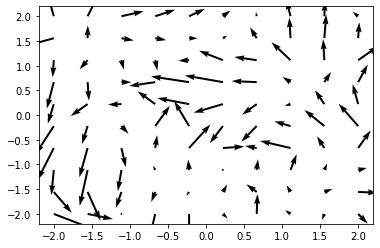

In [48]:
###### This isn't right - should be plotting mu
# Can we plot a meshgrid?

n = 10
t = T - 900

x = torch.linspace(2,-2, n)
grid_x, grid_y = torch.meshgrid(x, x, indexing='ij')
grid_x , grid_y = grid_x.flatten() , grid_y.flatten()

grid = torch.stack([grid_x,grid_y], dim = 1).to(device)
out = model(grid, t)

zx, zy = out[:,0].cpu().detach().numpy(), out[:,1].cpu().detach().numpy()
zx, zy = zx.reshape([n,n]),zy.reshape([n,n])
grid_x , grid_y = grid_x.reshape([n,n]).detach().numpy() , grid_y.reshape([n,n]).detach().numpy()

plt.quiver(x,x,zx - grid_x, zy - grid_y)

In [44]:
XT = torch.randn(1000,2).to(device)
X = XT.clone()
for t in range(T-1,0-1,-1):
    if t > 0:
        z = torch.randn_like(X)
    else:
        z = 0
            
    X = (X - betas[t] / (torch.sqrt(1 - alphabar[t])) * model(X,t)) / torch.sqrt(alphas[t]) + np.sqrt(betas[t]) * z
        
X = X.cpu().detach().numpy()  
XT = XT.cpu().detach().numpy()  

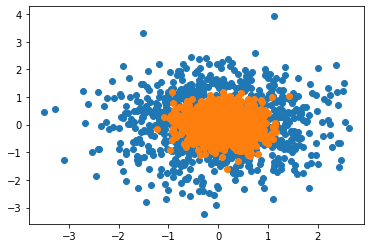

In [45]:
plt.scatter(XT[:,0],XT[:,1])
plt.scatter(X[:,0],X[:,1])
plt.show()